In [2]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import plotly.express as px
import plotly.graph_objects as go
import os # For creating output directories

# Display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x) # Format floats for better readability

# Create output directories if they don't exist
if not os.path.exists('output/plots'):
    os.makedirs('output/plots')
if not os.path.exists('output/interactive_plots'):
    os.makedirs('output/interactive_plots')
if not os.path.exists('output/processed_data'):
    os.makedirs('output/processed_data')

print("Libraries imported and directories checked/created.")

Libraries imported and directories checked/created.


In [3]:
# Cell 2: Load Data
# Make sure 'crypto_market_dataset.csv' is in the '../data/' directory relative to the notebook,
# or adjust the path accordingly. If the notebook is in the root of `crypto_risk_reward_analyzer`,
# then the path would be 'data/crypto_market_dataset.csv'.
# Assuming the notebook is in 'crypto_risk_reward_analyzer/notebooks/'
try:
    df_raw = pd.read_csv('../data/crypto_market_dataset.csv')
except FileNotFoundError:
    # Fallback if notebook is run from the project root
    df_raw = pd.read_csv('data/crypto_market_dataset.csv')

print("Dataset loaded successfully.")
df_raw.head()

Dataset loaded successfully.


,Name,Symbol,Current Price (USD),Market Cap,24h Change (%),Total Volume,Last Updated
0,Bitcoin,BTC,94344.00000,1873794852740,0.22055,30048904094.00000,2025-04-29T05:38:37.633Z
1,Ethereum,ETH,1794.84000,216622741611,0.00957,15289571994.00000,2025-04-29T05:38:38.924Z
2,Tether,USDT,1.00000,148003034455,0.00096,51289833984.00000,2025-04-29T05:38:42.109Z
3,XRP,XRP,2.28000,133031832238,-0.17409,3342810123.00000,2025-04-29T05:38:38.884Z
4,BNB,BNB,607.44000,88597084266,0.55653,621957431.00000,2025-04-29T05:38:37.053Z


In [4]:
# Cell 3: Initial Data Inspection
print("--- Dataset Info ---")
df_raw.info()
print("\n--- Dataset Description (Numerical) ---")
print(df_raw.describe())
print("\n--- Dataset Description (All) ---")
print(df_raw.describe(include='all'))
print(f"\n--- Shape of raw dataset: {df_raw.shape} ---")

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 1000 non-null   object 
 1   Symbol               1000 non-null   object 
 2   Current Price (USD)  1000 non-null   float64
 3   Market Cap           1000 non-null   int64  
 4   24h Change (%)       992 non-null    float64
 5   Total Volume         1000 non-null   float64
 6   Last Updated         1000 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 54.8+ KB

--- Dataset Description (Numerical) ---
       Current Price (USD)          Market Cap  24h Change (%)  \
count           1000.00000          1000.00000       992.00000   
mean            2379.99033    3103519483.01200         1.46345   
std            14390.80177   60106602394.30482         5.56163   
min                0.00000      25849772.00000       -23

In [5]:
# Cell 4: Data Cleaning and Preprocessing
df = df_raw.copy()

# Convert 'Last Updated' to datetime
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

# Handle missing '24h Change (%)' - Decision: Impute with 0 for now,
# but removing stale/incomplete rows might be better for a refined analysis.
# Let's identify them first.
missing_change_mask = df['24h Change (%)'].isnull()
print(f"Rows with missing '24h Change (%)': {missing_change_mask.sum()}")
print("Coins with missing 24h Change (%):")
print(df[missing_change_mask][['Name', 'Last Updated']])
df['24h Change (%)'].fillna(0, inplace=True)

# Ensure numeric types for key columns (Pandas often infers correctly, but explicit is good)
cols_to_numeric = ['Current Price (USD)', 'Market Cap', '24h Change (%)', 'Total Volume']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce') # Coerce will turn non-convertibles to NaN

# Drop rows if critical numeric conversions failed (created NaNs)
df.dropna(subset=cols_to_numeric, inplace=True)


# Filter out coins with effectively no market presence or special non-traded assets
initial_rows = len(df)
# Coins with 0 market cap AND 0 volume are generally not active.
df = df[~((df['Market Cap'] == 0) & (df['Total Volume'] == 0))]

# Filter out specific entities that are not typical actively traded cryptos if they skew analysis
# (e.g., tokenized funds with no public trading volume in this snapshot)
special_entities_to_filter = [
    'BlackRock USD Institutional Digital Liquidity Fund',
    'OUSG', 'cWBTC', 'Nexus Mutual', 'Spiko EU T-Bills Money Market Fund', 'GAMA Coin',
    'Apollo Diversified Credit Securitize Fund', 'Sygnum FIUSD Liquidity Fund',
    'Steakhouse USDC Morpho Vault', 'Resolv wstUSR', 'Defiway' # Adding some with very old/minimal data
]
df = df[~df['Name'].isin(special_entities_to_filter)]

# Filter out rows with extremely low 'Total Volume' (e.g., less than $100) as they are illiquid and can skew liquidity ratios.
# This is a judgment call.
min_volume_threshold = 100
df = df[df['Total Volume'] >= min_volume_threshold]

print(f"Rows removed by cleaning/filtering: {initial_rows - len(df)}")
df.reset_index(drop=True, inplace=True)
print(f"Shape of cleaned dataset: {df.shape}")
df.head()

Rows with missing '24h Change (%)': 8
Coins with missing 24h Change (%):
                 Name                     Last Updated
154              uBTC 2025-04-25 10:06:09.715000+00:00
308         GAMA Coin 2025-04-23 10:11:02.767000+00:00
324              RCGE 2024-12-07 21:06:42.704000+00:00
500      UXD Protocol 2025-04-13 21:36:04.685000+00:00
700  Jumbo Blockchain 2025-03-11 15:35:30.481000+00:00
776     Resolv wstUSR 2025-04-25 03:52:51.947000+00:00
932       MoonRabbits 2024-12-20 17:04:21.605000+00:00
977        Whiteheart 2025-04-27 02:14:46.142000+00:00
Rows removed by cleaning/filtering: 25
Shape of cleaned dataset: (975, 7)


C:\Users\Dean\AppData\Local\Temp\ipykernel_56408\4128904227.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['24h Change (%)'].fillna(0, inplace=True)


,Name,Symbol,Current Price (USD),Market Cap,24h Change (%),Total Volume,Last Updated
0,Bitcoin,BTC,94344.00000,1873794852740,0.22055,30048904094.00000,2025-04-29 05:38:37.633000+00:00
1,Ethereum,ETH,1794.84000,216622741611,0.00957,15289571994.00000,2025-04-29 05:38:38.924000+00:00
2,Tether,USDT,1.00000,148003034455,0.00096,51289833984.00000,2025-04-29 05:38:42.109000+00:00
3,XRP,XRP,2.28000,133031832238,-0.17409,3342810123.00000,2025-04-29 05:38:38.884000+00:00
4,BNB,BNB,607.44000,88597084266,0.55653,621957431.00000,2025-04-29 05:38:37.053000+00:00


In [6]:
# Cell 5: Feature Engineering
# Log Transformations (log1p handles zeros gracefully by adding 1 before log)
df['Market Cap Log'] = np.log1p(df['Market Cap'])
df['Total Volume Log'] = np.log1p(df['Total Volume'])
df['Current Price Log'] = np.log1p(df['Current Price (USD)']) # Price can be very small

# Liquidity Ratio
df['Liquidity Ratio'] = df['Total Volume'] / df['Market Cap']
# Handle potential division by zero or infinities if Market Cap was zero (though we filtered most)
df['Liquidity Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
# For any remaining NaNs (e.g., if Market Cap was 0 and Total Volume was not, or vice-versa after filtering)
df['Liquidity Ratio'].fillna(0, inplace=True) # Treat as 0 liquidity

# Absolute 24h Change (Volatility proxy)
df['Absolute 24h Change'] = abs(df['24h Change (%)'])

# Stablecoin Identifier (Heuristic)
# Price near $1, very low volatility. Adjust criteria as needed.
df['Is Stablecoin'] = (
    (df['Current Price (USD)'] >= 0.97) &  # Slightly wider price range
    (df['Current Price (USD)'] <= 1.03) &
    (df['Absolute 24h Change'] < 0.5)    # Slightly wider volatility range for stablecoins
)
print(f"Number of potential stablecoins identified: {df['Is Stablecoin'].sum()}")
print("Examples of identified stablecoins:")
print(df[df['Is Stablecoin']][['Name', 'Current Price (USD)', 'Absolute 24h Change']].head())

# Create a DataFrame for analysis, excluding stablecoins for the main risk/reward plot
df_analysis = df[~df['Is Stablecoin']].copy()
# Fallback if too many are filtered, or if you want to include stablecoins with a note
if len(df_analysis) < 0.3 * len(df): # If more than 70% are stablecoins (unlikely, but safety)
    print("Warning: A very large portion of data was filtered as stablecoins. Analyzing all data.")
    df_analysis = df.copy()
else:
    print(f"Proceeding with {len(df_analysis)} non-stablecoins for main analysis.")

df_analysis.head()

Number of potential stablecoins identified: 73
Examples of identified stablecoins:
                                      Name  Current Price (USD)  \
2                                   Tether              1.00000   
6                                     USDC              0.99993   
20                                    USDS              0.99989   
26  Binance Bridged USDT (BNB Smart Chain)              1.00100   
30                             Ethena USDe              0.99949   

    Absolute 24h Change  
2               0.00096  
6               0.00233  
20              0.00105  
26              0.02916  
30              0.00300  
Proceeding with 902 non-stablecoins for main analysis.


C:\Users\Dean\AppData\Local\Temp\ipykernel_56408\663601691.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Liquidity Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Dean\AppData\Local\Temp\ipykernel_56408\663601691.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

,Name,Symbol,Current Price (USD),Market Cap,24h Change (%),Total Volume,Last Updated,Market Cap Log,Total Volume Log,Current Price Log,Liquidity Ratio,Absolute 24h Change,Is Stablecoin
0,Bitcoin,BTC,94344.00000,1873794852740,0.22055,30048904094.00000,2025-04-29 05:38:37.633000+00:00,28.25899,24.12609,11.45471,0.01604,0.22055,False
1,Ethereum,ETH,1794.84000,216622741611,0.00957,15289571994.00000,2025-04-29 05:38:38.924000+00:00,26.10142,23.45044,7.49323,0.07058,0.00957,False
3,XRP,XRP,2.28000,133031832238,-0.17409,3342810123.00000,2025-04-29 05:38:38.884000+00:00,25.61385,21.93008,1.18784,0.02513,0.17409,False
4,BNB,BNB,607.44000,88597084266,0.55653,621957431.00000,2025-04-29 05:38:37.053000+00:00,25.20736,20.24838,6.41090,0.00702,0.55653,False
5,Solana,SOL,146.64000,75780493084,-1.70648,3456354735.00000,2025-04-29 05:38:37.409000+00:00,25.05111,21.96348,4.99478,0.04561,1.70648,False


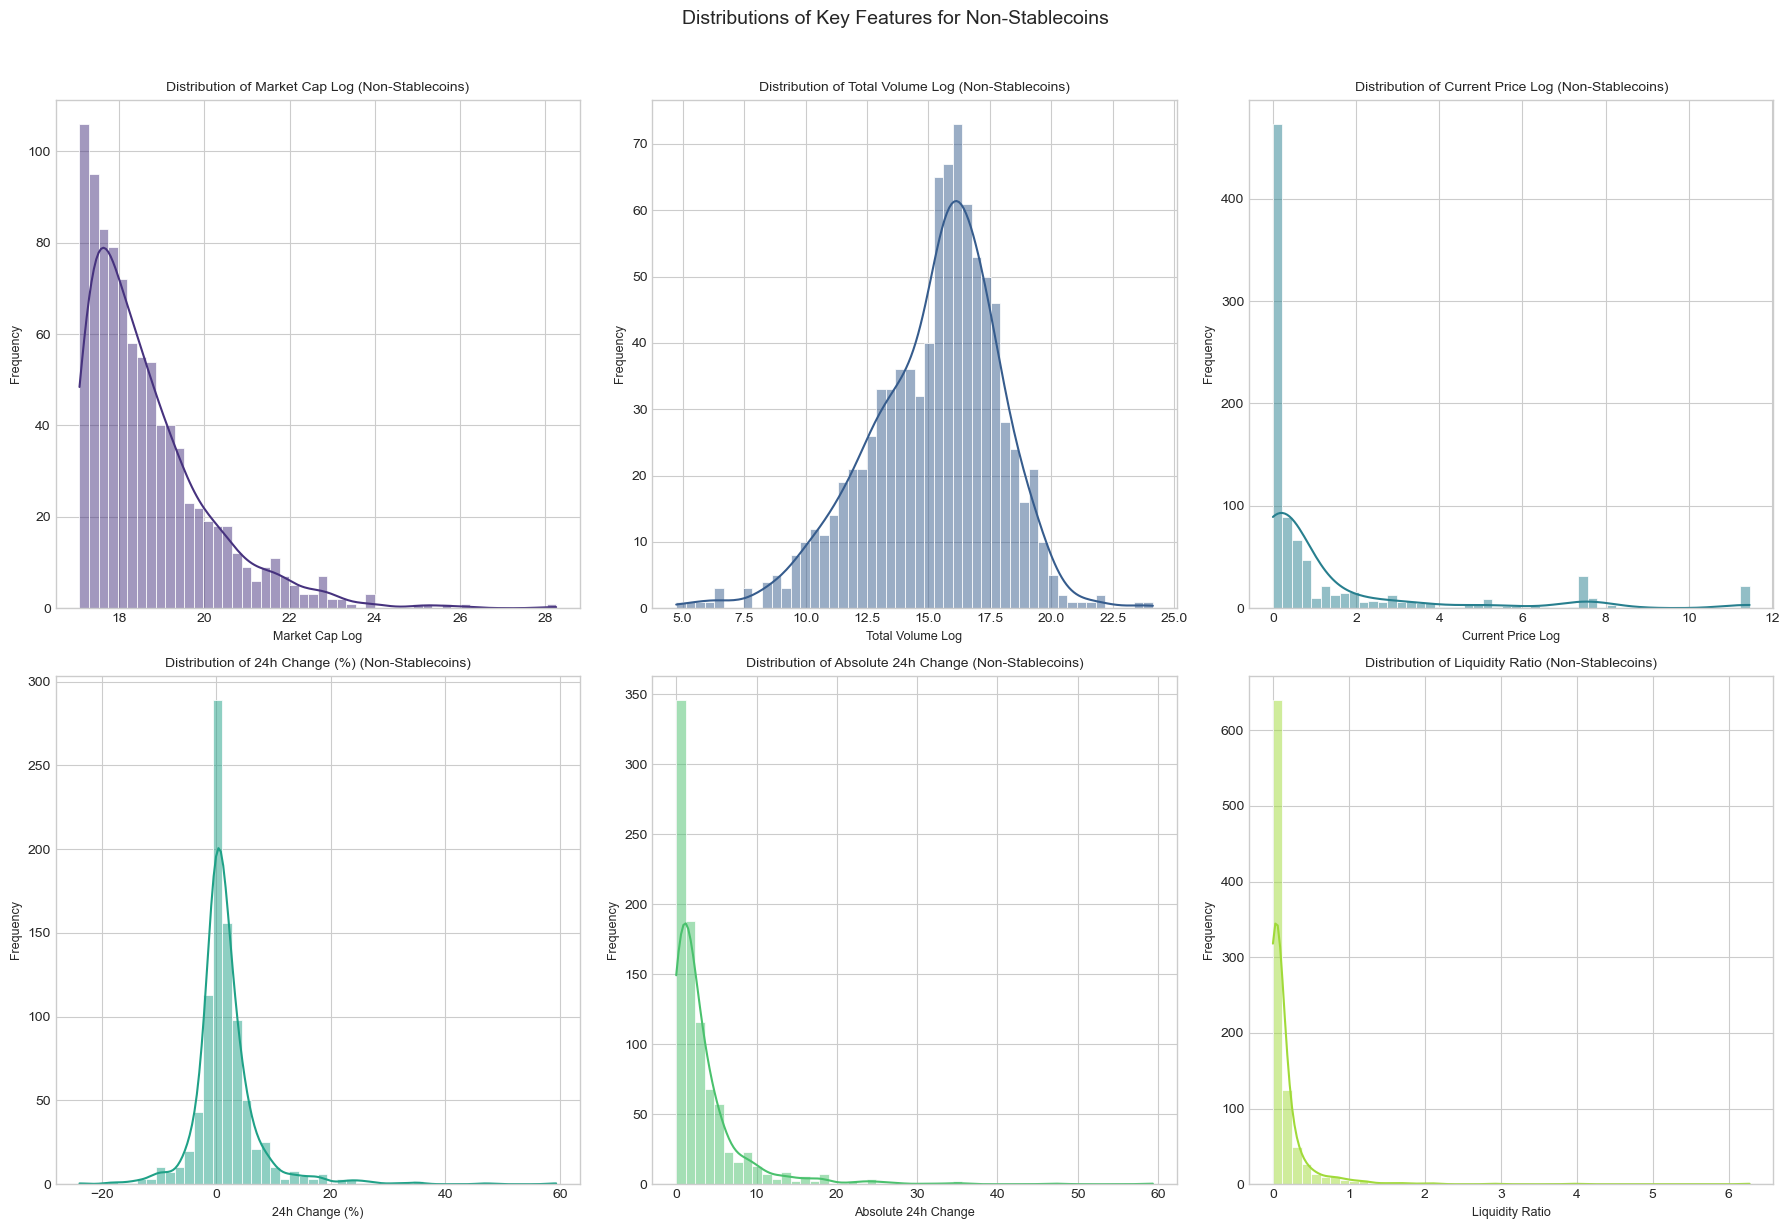

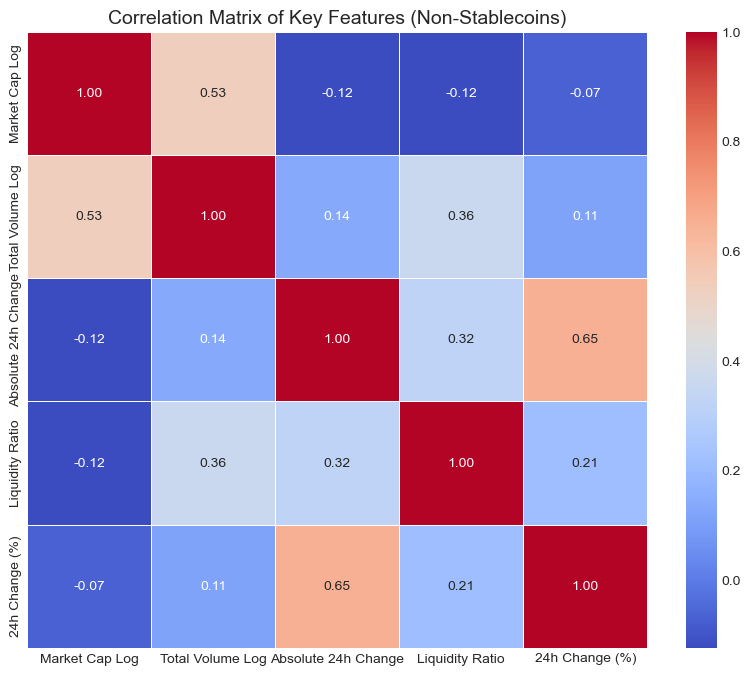

In [7]:
# Cell 6: Exploratory Data Analysis (EDA) - Visualizations
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style

features_to_plot = ['Market Cap Log', 'Total Volume Log', 'Current Price Log',
                    '24h Change (%)', 'Absolute 24h Change', 'Liquidity Ratio']
plt.figure(figsize=(18, 12))
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 3, i + 1)
    # Plotting for df_analysis (non-stablecoins) as it's the primary focus
    sns.histplot(df_analysis[col].dropna(), kde=True, bins=50, color=sns.color_palette("viridis")[i%6])
    plt.title(f'Distribution of {col} (Non-Stablecoins)', fontsize=10)
    plt.xlabel(col, fontsize=9)
    plt.ylabel('Frequency', fontsize=9)
plt.suptitle('Distributions of Key Features for Non-Stablecoins', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('output/plots/eda_feature_distributions.png')
plt.show()

# Correlation Heatmap for features used in scoring (on non-stablecoin data)
numeric_cols_for_corr = ['Market Cap Log', 'Total Volume Log', 'Absolute 24h Change',
                         'Liquidity Ratio', '24h Change (%)']
correlation_matrix = df_analysis[numeric_cols_for_corr].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Features (Non-Stablecoins)', fontsize=14)
plt.savefig('output/plots/eda_correlation_heatmap.png')
plt.show()

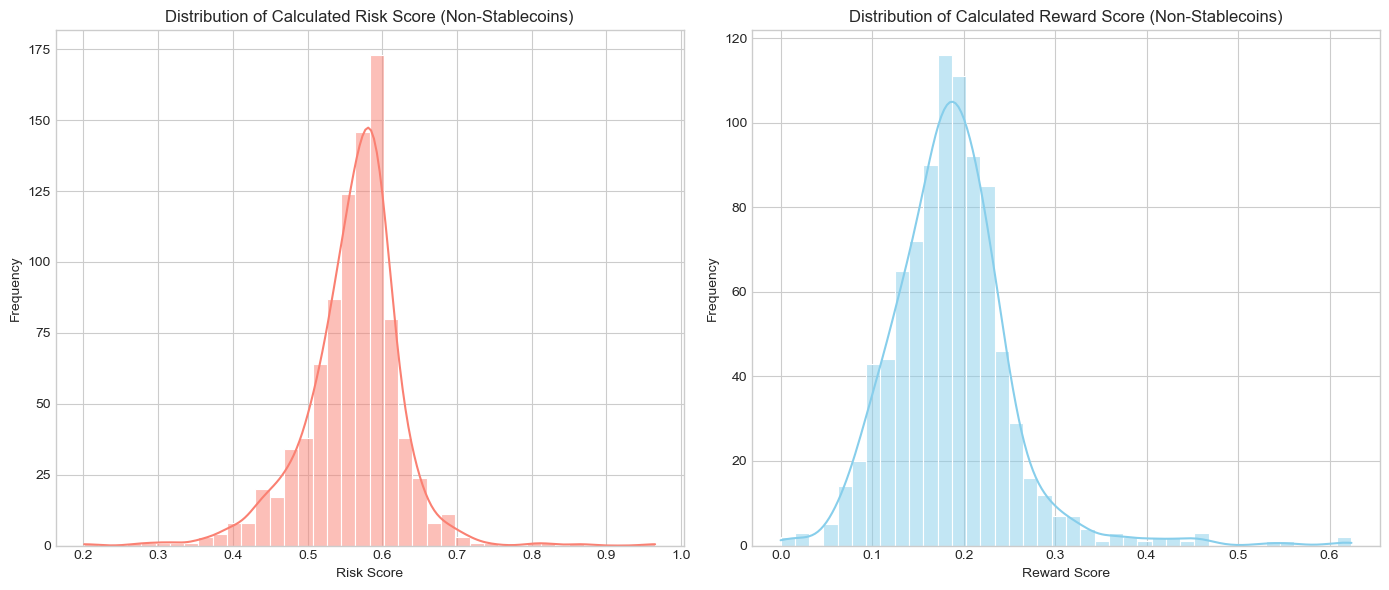

,Name,Risk Score,Reward Score
0,Bitcoin,0.20098,0.30225
1,Ethereum,0.27493,0.29298
3,XRP,0.29492,0.26722
4,BNB,0.31260,0.24407
5,Solana,0.32470,0.26871


In [8]:
# Cell 7: Risk & Reward Score Calculation
# Initialize Scaler
scaler = MinMaxScaler()

# --- Risk Components ---
# Lower Market Cap = Higher Risk (Inverse relationship)
# We scale the negative log market cap, so smaller caps get higher scores after scaling.
df_analysis['Risk_MarketCap_Inv_Scaled'] = scaler.fit_transform(
    (-df_analysis['Market Cap Log']).to_frame()
)

# Higher Absolute Volatility = Higher Risk
df_analysis['Risk_Volatility_Scaled'] = scaler.fit_transform(
    df_analysis['Absolute 24h Change'].to_frame()
)

# Lower Liquidity Ratio = Higher Risk (Inverse relationship)
# Scale Liquidity Ratio first, then invert (1 - scaled_value)
df_analysis['Liquidity_Ratio_Scaled'] = scaler.fit_transform(
    df_analysis['Liquidity Ratio'].to_frame()
)
df_analysis['Risk_Liquidity_Inv_Scaled'] = 1 - df_analysis['Liquidity_Ratio_Scaled']


# --- Reward/Activity Components ---
# Higher Positive 24h Change = Higher Reward (Clip negative changes at 0)
df_analysis['Reward_24hChange_Scaled'] = scaler.fit_transform(
    df_analysis['24h Change (%)'].clip(lower=0).to_frame()
)

# Higher Log Total Volume = Higher Activity/Potential Reward
df_analysis['Reward_Volume_Scaled'] = scaler.fit_transform(
    df_analysis['Total Volume Log'].to_frame()
)

# Higher Liquidity Ratio = Higher Reward (ability to realize gains)
df_analysis['Reward_Liquidity_Scaled'] = df_analysis['Liquidity_Ratio_Scaled'] # Re-use already scaled version


# --- Define Weights (CRITICAL: These are subjective and should be justified/explored) ---
weights_risk = {'MarketCap': 0.4, 'Volatility': 0.4, 'Liquidity': 0.2}
weights_reward = {'24hChange': 0.4, 'Volume': 0.3, 'Liquidity': 0.3}

# --- Calculate Final Scores ---
df_analysis['Risk Score'] = (
    weights_risk['MarketCap'] * df_analysis['Risk_MarketCap_Inv_Scaled'] +
    weights_risk['Volatility'] * df_analysis['Risk_Volatility_Scaled'] +
    weights_risk['Liquidity'] * df_analysis['Risk_Liquidity_Inv_Scaled']
)
df_analysis['Reward Score'] = (
    weights_reward['24hChange'] * df_analysis['Reward_24hChange_Scaled'] +
    weights_reward['Volume'] * df_analysis['Reward_Volume_Scaled'] +
    weights_reward['Liquidity'] * df_analysis['Reward_Liquidity_Scaled']
)

# Visualize distribution of final scores
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_analysis['Risk Score'], kde=True, bins=40, color='salmon')
plt.title('Distribution of Calculated Risk Score (Non-Stablecoins)', fontsize=12)
plt.xlabel('Risk Score', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.subplot(1, 2, 2)
sns.histplot(df_analysis['Reward Score'], kde=True, bins=40, color='skyblue')
plt.title('Distribution of Calculated Reward Score (Non-Stablecoins)', fontsize=12)
plt.xlabel('Reward Score', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.savefig('output/plots/risk_reward_score_distributions.png')
plt.show()

df_analysis[['Name', 'Risk Score', 'Reward Score']].head()

In [9]:
# Cell 8: Anomaly Detection
# Features for anomaly detection (these describe fundamental characteristics)
features_for_anomaly = ['Absolute 24h Change', 'Liquidity Ratio', 'Market Cap Log']
X_anomaly = df_analysis[features_for_anomaly].copy()

# Fill any potential NaNs that might have slipped through or been created (e.g. if Liquidity Ratio was Inf then 0)
X_anomaly.fillna(X_anomaly.median(), inplace=True) # Impute with median for robustness

# Scale these features
scaler_anomaly = MinMaxScaler()
X_anomaly_scaled = scaler_anomaly.fit_transform(X_anomaly)

# Initialize and fit Isolation Forest
# Contamination: Expected proportion of outliers. Adjust based on domain knowledge or experimentation.
# Common values are 0.01 to 0.05 (1% to 5%)
iso_forest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42) # 'behaviour' is deprecated, contamination auto is preferred in newer versions
# If 'behaviour' causes an error with your scikit-learn version, remove it or set contamination='auto' if supported, or use an explicit float.
# For scikit-learn >= 0.22, 'behaviour' is deprecated. If using older, keep 'new'.
# Let's assume a newer version and rely on explicit contamination float.
try:
    iso_forest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
    df_analysis['Anomaly_Pred_IF'] = iso_forest.fit_predict(X_anomaly_scaled)
except TypeError: # Fallback for older sklearn versions that might need 'behaviour'
    iso_forest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42, behaviour='new')
    df_analysis['Anomaly_Pred_IF'] = iso_forest.fit_predict(X_anomaly_scaled)


# Anomaly_Pred_IF: -1 indicates an anomaly, 1 indicates normal
df_analysis['Is_Anomaly_IF'] = (df_analysis['Anomaly_Pred_IF'] == -1)

print(f"Number of anomalies detected by Isolation Forest: {df_analysis['Is_Anomaly_IF'].sum()}")

print("\nTop 10 Anomalous Coins (Sorted by Market Cap Desc):")
anomalous_coins_if = df_analysis[df_analysis['Is_Anomaly_IF']].sort_values(by='Market Cap', ascending=False)
display_cols_anomaly = ['Name', 'Symbol', 'Current Price (USD)', 'Market Cap', 'Total Volume',
                        '24h Change (%)', 'Absolute 24h Change', 'Liquidity Ratio',
                        'Risk Score', 'Reward Score']
print(anomalous_coins_if[display_cols_anomaly].head(10))

Number of anomalies detected by Isolation Forest: 28

Top 10 Anomalous Coins (Sorted by Market Cap Desc):
                                Name   Symbol  Current Price (USD)  \
0                            Bitcoin      BTC          94344.00000   
1                           Ethereum      ETH           1794.84000   
3                                XRP      XRP              2.28000   
4                                BNB      BNB            607.44000   
44                    Official Trump    TRUMP             14.07000   
92                 Virtuals Protocol  VIRTUAL              1.45000   
118                   Pudgy Penguins    PENGU              0.01152   
168  L2 Standard Bridged WETH (Base)     WETH           1794.54000   
198                            ai16z    AI16Z              0.30228   
222                     Moca Network     MOCA              0.10311   

        Market Cap      Total Volume  24h Change (%)  Absolute 24h Change  \
0    1873794852740 30048904094.00000         0

In [20]:
# Cell 9: Interactive Risk-Reward Scatter Plot with Plotly

# Market Cap Tier for better visual grouping in hover (optional)
mcap_bins = [0, 1e7, 1e8, 1e9, 1e11, np.inf] # Adjusted bins: Micro, Small, Mid, Large, Mega
mcap_labels = ['Micro Cap (<$10M)', 'Small Cap ($10M-$100M)', 'Mid Cap ($100M-$1B)', 'Large Cap ($1B-$100B)', 'Mega Cap (>$100B)']
df_analysis['Market Cap Tier'] = pd.cut(df_analysis['Market Cap'], bins=mcap_bins, labels=mcap_labels, right=False)

# --- FIX START (Using astype for robust category update) ---

# Check if the column is categorical and if there are NaNs that need filling
if isinstance(df_analysis['Market Cap Tier'].dtype, pd.CategoricalDtype) and df_analysis['Market Cap Tier'].isnull().any():
    # Get the current categories and ordered status
    current_categories = df_analysis['Market Cap Tier'].cat.categories.tolist()
    is_ordered = df_analysis['Market Cap Tier'].cat.ordered

    # Add 'N/A' to the list of categories if it's not already there
    if 'N/A' not in current_categories:
        new_categories = current_categories + ['N/A']
    else:
        new_categories = current_categories # 'N/A' already exists

    # Create a new CategoricalDtype with the (potentially) updated categories
    updated_categorical_dtype = pd.CategoricalDtype(categories=new_categories, ordered=is_ordered)

    # Recast the column with this new dtype. This ensures 'N/A' is a valid category.
    df_analysis['Market Cap Tier'] = df_analysis['Market Cap Tier'].astype(updated_categorical_dtype)

    # Now, fill the NaN values with 'N/A'.
    # Assign back to the column to be safe, though astype should have returned a new series that was assigned.
    df_analysis['Market Cap Tier'] = df_analysis['Market Cap Tier'].fillna('N/A')

elif df_analysis['Market Cap Tier'].isnull().any(): # If not categorical but has NaNs
    df_analysis['Market Cap Tier'] = df_analysis['Market Cap Tier'].fillna('N/A')
# If no NaNs, no fillna action is needed for this specific purpose.

# --- FIX END ---


# Ensure hover data doesn't cause issues if some values are NaN
cols_for_hover = {
    'Symbol': True,
    'Current Price (USD)': ':.3f',
    'Market Cap': ':,.0f',
    'Total Volume': ':,.0f',
    '24h Change (%)': ':.2f',
    'Liquidity Ratio': ':.4f',
    'Absolute 24h Change': ':.2f',
    'Risk Score': ':.3f',
    'Reward Score': ':.3f',
    'Market Cap Tier': True,
    'Market Cap Log': False
}

# Create the scatter plot
fig_risk_reward = px.scatter(
    df_analysis, # NaNs in 'Market Cap Tier' are now handled
    x='Risk Score',
    y='Reward Score',
    color='Is_Anomaly_IF',
    size='Market Cap Log',
    hover_name='Name',
    hover_data=cols_for_hover,
    color_discrete_map={True: 'rgba(255, 0, 0, 0.7)', False: 'rgba(0, 0, 255, 0.5)'},
    title='Crypto Risk vs. Reward Profile (Non-Stablecoins)',
    labels={'Risk Score': 'Calculated Risk Score (Higher = Riskier)',
            'Reward Score': 'Calculated Reward/Activity Score (Higher = More Reward/Activity)',
            'Is_Anomaly_IF': 'Is Anomaly?'}
)

# Add quadrant lines using mean scores
mean_risk = df_analysis['Risk Score'].mean()
mean_reward = df_analysis['Reward Score'].mean()

fig_risk_reward.add_vline(
    x=mean_risk, line_dash="dash", line_color="grey",
    annotation_text=f"Avg Risk: {mean_risk:.2f}", annotation_position="top right"
)
fig_risk_reward.add_hline(
    y=mean_reward, line_dash="dash", line_color="grey",
    annotation_text=f"Avg Reward: {mean_reward:.2f}", annotation_position="bottom right"
)

# Improve layout
fig_risk_reward.update_layout(
    height=750,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    title_font_size=18,
    legend_title_font_size=12,
    legend_font_size=10,
    showlegend=True
)
fig_risk_reward.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')))

# Show plot in notebook
fig_risk_reward.show()

# Save interactive plot to HTML
interactive_plot_path = 'output/interactive_plots/risk_reward_profile.html'
fig_risk_reward.write_html(interactive_plot_path)
print(f"Interactive plot saved to: {interactive_plot_path}")

Interactive plot saved to: output/interactive_plots/risk_reward_profile.html



--- Cell 10 Start Debug ---
Columns in df_analysis (start of Cell 10): ['Name', 'Symbol', 'Current Price (USD)', 'Market Cap', '24h Change (%)', 'Total Volume', 'Last Updated', 'Market Cap Log', 'Total Volume Log', 'Current Price Log', 'Liquidity Ratio', 'Absolute 24h Change', 'Is Stablecoin', 'Risk_MarketCap_Inv_Scaled', 'Risk_Volatility_Scaled', 'Liquidity_Ratio_Scaled', 'Risk_Liquidity_Inv_Scaled', 'Reward_24hChange_Scaled', 'Reward_Volume_Scaled', 'Reward_Liquidity_Scaled', 'Risk Score', 'Reward Score', 'Anomaly_Pred_IF', 'Is_Anomaly_IF', 'Market Cap Tier']
'Market Cap Tier' dtype in df_analysis: category
--------------------------
--- Quadrant Analysis (based on mean Risk/Reward) ---

1. Low Risk, High Reward (238 coins):
               Name  Risk Score  Reward Score  Market Cap  24h Change (%)
812  Alpaca Finance     0.47415       0.61081    36355670        12.81331
491            Sign     0.47829       0.46701    86665867         7.03775
860      Bubblemaps     0.54883       0.

In [26]:
# Cell 10: Analysis of Quadrants and Anomalies

# --- Cell 10 Start Debug ---
print("\n--- Cell 10 Start Debug ---")
if 'Market Cap Tier' in df_analysis.columns:
    print("Columns in df_analysis (start of Cell 10):", df_analysis.columns.tolist())
    if not df_analysis.empty:
        print("'Market Cap Tier' dtype in df_analysis:", df_analysis['Market Cap Tier'].dtype)
else:
    print("'Market Cap Tier' IS MISSING from df_analysis at start of Cell 10!")
print("--------------------------")
# --- End Cell 10 Start Debug ---


print("--- Quadrant Analysis (based on mean Risk/Reward) ---")
if not df_analysis.empty:
    mean_risk = df_analysis['Risk Score'].mean()
    mean_reward = df_analysis['Reward Score'].mean()

    low_risk_high_reward = df_analysis[
        (df_analysis['Risk Score'] < mean_risk) & (df_analysis['Reward Score'] > mean_reward)
    ]
    high_risk_high_reward = df_analysis[
        (df_analysis['Risk Score'] > mean_risk) & (df_analysis['Reward Score'] > mean_reward)
    ]
    low_risk_low_reward = df_analysis[
        (df_analysis['Risk Score'] < mean_risk) & (df_analysis['Reward Score'] < mean_reward)
    ]
    high_risk_low_reward = df_analysis[
        (df_analysis['Risk Score'] > mean_risk) & (df_analysis['Reward Score'] < mean_reward)
    ]

    print(f"\n1. Low Risk, High Reward ({len(low_risk_high_reward)} coins):")
    print(low_risk_high_reward[['Name', 'Risk Score', 'Reward Score', 'Market Cap', '24h Change (%)']].sort_values(by='Reward Score', ascending=False).head())

    print(f"\n2. High Risk, High Reward ({len(high_risk_high_reward)} coins):")
    print(high_risk_high_reward[['Name', 'Risk Score', 'Reward Score', 'Market Cap', '24h Change (%)']].sort_values(by='Reward Score', ascending=False).head())

    print(f"\n3. Low Risk, Low Reward ({len(low_risk_low_reward)} coins):")
    print(low_risk_low_reward[['Name', 'Risk Score', 'Reward Score', 'Market Cap', '24h Change (%)']].sort_values(by='Risk Score', ascending=True).head())

    print(f"\n4. High Risk, Low Reward ({len(high_risk_low_reward)} coins):")
    print(high_risk_low_reward[['Name', 'Risk Score', 'Reward Score', 'Market Cap', '24h Change (%)']].sort_values(by='Risk Score', ascending=False).head())
else:
    print("df_analysis is empty, skipping quadrant analysis.")


print("\n--- Detailed Look at Top Anomalies (by Market Cap) ---")
# Filter for anomalous coins directly from the current df_analysis
# This ensures 'Market Cap Tier' is included if it exists in df_analysis
current_anomalous_coins = df_analysis[df_analysis['Is_Anomaly_IF']].sort_values(by='Market Cap', ascending=False)

if not current_anomalous_coins.empty:
    # Define columns for display, including 'Market Cap Tier' if available
    # display_cols_anomaly was defined in Cell 8, we'll reconstruct a similar list here for clarity
    base_display_cols = ['Name', 'Symbol', 'Current Price (USD)', 'Market Cap', 'Total Volume',
                         '24h Change (%)', 'Absolute 24h Change', 'Liquidity Ratio',
                         'Risk Score', 'Reward Score']
    
    if 'Market Cap Tier' in current_anomalous_coins.columns:
        final_display_cols_for_anomalies = base_display_cols + ['Market Cap Tier']
    else:
        final_display_cols_for_anomalies = base_display_cols
        print("Warning: 'Market Cap Tier' not found in current_anomalous_coins. Displaying without it.")

    top_anomalies_detailed = current_anomalous_coins[final_display_cols_for_anomalies].head(5)
    
    for idx, row in top_anomalies_detailed.iterrows():
        print(f"\nAnomaly: {row['Name']} ({row['Symbol']})")
        print(f"  Price: ${row['Current Price (USD)']:.2f}, 24h Change: {row['24h Change (%)']:.2f}%")
        print(f"  Market Cap: ${row['Market Cap']:,.0f}", end="")
        if 'Market Cap Tier' in row and pd.notna(row['Market Cap Tier']):
            print(f" ({row['Market Cap Tier']})")
        else:
            print()
        print(f"  Volume: ${row['Total Volume']:,.0f}, Liquidity Ratio: {row['Liquidity Ratio']:.4f}")
        print(f"  Abs 24h Change: {row['Absolute 24h Change']:.2f}%")
        print(f"  Risk Score: {row['Risk Score']:.3f}, Reward Score: {row['Reward Score']:.3f}")
        if abs(row['24h Change (%)']) > 10:
            print(f"  Insight: High 24h price volatility.")
        if row['Liquidity Ratio'] < 0.001 and row['Market Cap'] > 1e8:
            print(f"  Insight: Potentially very low liquidity for its size.")
        if row['Liquidity Ratio'] > 1 and row['Market Cap'] < 1e7:
            print(f"  Insight: Unusually high trading activity for a small coin.")
else:
    print("No anomalous coins found in the current df_analysis.")


--- Cell 10 Start Debug ---
Columns in df_analysis (start of Cell 10): ['Name', 'Symbol', 'Current Price (USD)', 'Market Cap', '24h Change (%)', 'Total Volume', 'Last Updated', 'Market Cap Log', 'Total Volume Log', 'Current Price Log', 'Liquidity Ratio', 'Absolute 24h Change', 'Is Stablecoin', 'Risk_MarketCap_Inv_Scaled', 'Risk_Volatility_Scaled', 'Liquidity_Ratio_Scaled', 'Risk_Liquidity_Inv_Scaled', 'Reward_24hChange_Scaled', 'Reward_Volume_Scaled', 'Reward_Liquidity_Scaled', 'Risk Score', 'Reward Score', 'Anomaly_Pred_IF', 'Is_Anomaly_IF', 'Market Cap Tier']
'Market Cap Tier' dtype in df_analysis: category
--------------------------
--- Quadrant Analysis (based on mean Risk/Reward) ---

1. Low Risk, High Reward (238 coins):
               Name  Risk Score  Reward Score  Market Cap  24h Change (%)
812  Alpaca Finance     0.47415       0.61081    36355670        12.81331
491            Sign     0.47829       0.46701    86665867         7.03775
860      Bubblemaps     0.54883       0.

In [27]:
# Cell 11: Saving Processed Data (Optional)
processed_data_path = 'output/processed_data/crypto_data_with_scores.csv'
df_analysis.to_csv(processed_data_path, index=False)
print(f"\nProcessed data with scores and anomaly flags saved to: {processed_data_path}")

# Also save the full df (including stablecoins, but with engineered features) if useful
full_df_processed_path = 'output/processed_data/full_crypto_data_engineered.csv'
# Recalculate scores for stablecoins if they were excluded, or save df before splitting
# For simplicity here, we just save the df_analysis.
# If you need scores for ALL coins, you'd run the scoring on the full 'df'.
print("Analysis complete.")


Processed data with scores and anomaly flags saved to: output/processed_data/crypto_data_with_scores.csv
Analysis complete.
